In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import tensorflow as tf
# download TA-Lib 
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!ls

!tar xvzf ta-lib-0.4.0-src.tar.gz
!ls
import os
os.chdir('ta-lib') # Can't use !cd in co-lab
!./configure --prefix=/usr
!make

!make install
# wait ~ 30s

os.chdir('../')
!ls

!pip install TA-Lib 

--2021-11-15 06:22:04--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-11-15 06:22:04--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-11-15 06:22:05--  http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving nchc.dl.sourceforge.n

In [ ]:
import talib as ta

In [ ]:
data = pd.read_csv("AUD_CAD_H1.csv")

In [ ]:
data

,datetime,open,high,low,close
0,2005-01-02T18:00:00.000000000Z,0.93884,0.94353,0.93884,0.94353
1,2005-01-02T19:00:00.000000000Z,0.94317,0.94460,0.94291,0.94460
2,2005-01-02T20:00:00.000000000Z,0.94406,0.94433,0.93813,0.93910
3,2005-01-02T21:00:00.000000000Z,0.93936,0.93936,0.93822,0.93858
4,2005-01-02T22:00:00.000000000Z,0.93874,0.94007,0.93813,0.94007
...,...,...,...,...,...
102902,2021-02-26T18:00:00.000000000Z,0.98164,0.98232,0.98040,0.98127
102903,2021-02-26T19:00:00.000000000Z,0.98127,0.98145,0.97948,0.97965
102904,2021-02-26T20:00:00.000000000Z,0.97967,0.98093,0.97907,0.97932
102905,2021-02-26T21:00:00.000000000Z,0.97933,0.98286,0.97894,0.98147


In [ ]:
data.index = pd.to_datetime(data.datetime)
data=data.drop(['datetime'],axis=1)
data.sort_values(by = 'datetime', ascending = True, inplace = True)

In [ ]:
# data= data.dropna()
# len(data)

In [ ]:
# def get_TA(df_test):
#   df_test['MA_50'] = ta.SMA(df_test['close'],20)
#   df_test['MA_100'] = ta.SMA(df_test['close'],20)
#   df_test['Relative'] = ta.RSI(df_test['close'],14)
#   df_test['EMA'] = ta.EMA(df_test['close'], timeperiod = 20)
#   df_test['up_band'], df_test['mid_band'], df_test['low_band'] = ta.BBANDS(df_test['close'], timeperiod =20)
#   df_test['macd'], df_test['macdsignal'], df_test['macdhist'] = ta.MACD(df_test['close'], fastperiod=12, slowperiod=26, signalperiod=9)
#   df_test['avg'] = ta.ADX(df_test['high'],df_test['low'], df_test['close'], timeperiod=20)
  

#   return df_test


  

In [ ]:

# data_preprocess2(data)

In [ ]:
def data_preprocess(data, pips = 0.00001, pt = 100, sl = 100, window_size = 5, num_features = 225):
    def getHandL_next_N_window(data, windowSize):
        def idx_max(x):
            return x.index.values[np.argmax(x.values)]
        def idx_min(x):
            return x.index.values[np.argmin(x.values)]
        data_max_next = data['high'].rolling(windowSize).agg(['max', idx_max]).shift(-1*windowSize+1)
        data_min_next = data['low'].rolling(windowSize).agg(['min', idx_min]).shift(-1*windowSize+1)
        data_merged = pd.concat([data, data_max_next, data_min_next], axis=1)
        data_merged = data_merged.rename(columns={'max': 'hh_next_'+str(windowSize), 'idx_max': 'hh_next_idx_'+str(windowSize), 'min': 'll_next_'+str(windowSize), 'idx_min': 'll_next_idx_'+str(windowSize)})
        return data_merged
    
    data = getHandL_next_N_window(data, window_size)
    data['hh_diff_'+str(window_size)]=(data['hh_next_'+str(window_size)]-data['open'])/pips
    data['ll_diff_'+str(window_size)]=(data['open']-data['ll_next_'+str(window_size)])/pips
    conditions = [
        (data['hh_diff_'+str(window_size)]>pt) & (data['ll_diff_'+str(window_size)]<sl),
        (data['hh_diff_'+str(window_size)]>pt) & (data['ll_diff_'+str(window_size)]>sl)
                & (data['hh_next_idx_'+str(window_size)]<data['ll_next_idx_'+str(window_size)]),
        (data['ll_diff_'+str(window_size)]>pt) & (data['hh_diff_'+str(window_size)]<sl),
        (data['ll_diff_'+str(window_size)]>pt) & (data['hh_diff_'+str(window_size)]>sl)
                & (data['ll_next_idx_'+str(window_size)]<data['hh_next_idx_'+str(window_size)]),
    ]
    labels = [0,0,2,2]
    data['label_'+str(window_size)] = np.select(conditions, labels, default=1)

    data['MA_50'] = ta.SMA(data['close'],50)
    data['MA_100'] = ta.SMA(data['close'],100)
    data['Relative'] = ta.RSI(data['close'],14)
    data['EMA'] = ta.EMA(data['close'], timeperiod = 20)
    data['up_band'], data['mid_band'], data['low_band'] = ta.BBANDS(data['close'], timeperiod =20)
    data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    data['avg'] = ta.ADX(data['high'],data['low'], data['close'], timeperiod=20)
    data = data.dropna(axis=0,how='any')

    


  
    train = data.iloc[:int(len(data) * 0.8),:]
    valid = data.iloc[int(len(data) * 0.8):int(len(data) * 0.9),:]
    test = data.iloc[int(len(data) * 0.9):len(data),:]

  
  
    def pre_process(df):
      x_data = df.drop(['close','label_5'], axis = 1)

      y_data = df.loc[:,'close']
      # x_data = pd.DataFrame(data.iloc[:,data.colums])
      return x_data, y_data
    

    X_train, y_train = pre_process(train)
    X_val, y_val = pre_process(valid)
    X_test, y_test = pre_process(test)

    def data_transform(x,y):
      
      from sklearn.preprocessing import MinMaxScaler
      scaler=MinMaxScaler(feature_range=(0,1))
      x=scaler.fit_transform(np.array(x))  
      y=scaler.fit_transform(np.array(y).reshape(-1,1))  
      

      return x,y 

    X_train, y_train = data_transform(X_train, y_train)
    X_val, y_val =data_transform(X_val,y_val)
    X_test,y_test = data_transform(X_test,y_test)


    import numpy
  # convert an array of values into a dataset matrix
    def create_dataset(x,y, time_step=1):
      dataX, dataY = [], []
      for i in range(len(x)-time_step-1):
          a = x[i:(i+time_step), :]   ###i=0, 0,1,2,3-----99   100 
          dataX.append(a)
          dataY.append(x[i, 1])
          #dataY.append(x[i  : i + time_step])
      
      return numpy.array(dataX), numpy.array(dataY)

    time_step = 100

    X_train, y_train = create_dataset(X_train,y_train,time_step)
    X_val, y_val = create_dataset(X_val,y_val,time_step)
    X_test, y_test = create_dataset(X_test,y_test,time_step)



    return X_train, y_train , X_val,y_val,X_test,y_test

In [ ]:
 X_train, y_train , X_val,y_val,X_test,y_test= data_preprocess(data)

#data.head()

In [ ]:
X_train

array([[[0.60789243, 0.59561876, 0.61749119, ..., 0.61435076,
         0.55949971, 0.25552755],
        [0.6096438 , 0.59823926, 0.61873977, ..., 0.61934796,
         0.56103637, 0.26259692],
        [0.61340075, 0.59873981, 0.61968314, ..., 0.62440499,
         0.56152518, 0.27002997],
        ...,
        [0.55583176, 0.53890999, 0.56496768, ..., 0.48550598,
         0.51503479, 0.46978697],
        [0.55727239, 0.54017607, 0.56591105, ..., 0.48657241,
         0.52892155, 0.47603833],
        [0.55701816, 0.54091217, 0.56613302, ..., 0.48913927,
         0.54118016, 0.48017322]],

       [[0.6096438 , 0.59823926, 0.61873977, ..., 0.61934796,
         0.56103637, 0.26259692],
        [0.61340075, 0.59873981, 0.61968314, ..., 0.62440499,
         0.56152518, 0.27002997],
        [0.61441767, 0.59873981, 0.61701951, ..., 0.62776403,
         0.54765241, 0.2703277 ],
        ...,
        [0.55727239, 0.54017607, 0.56591105, ..., 0.48657241,
         0.52892155, 0.47603833],
        [0.5

In [ ]:
# print(len(data))

# train = data.iloc[:int(len(data) * 0.8),:]
# valid = data.iloc[int(len(data) * 0.8):int(len(data) * 0.9),:]
# test = data.iloc[int(len(data) * 0.9):len(data),:]

In [ ]:

# def pre_process(df):
#   x_data = df.drop(['close','label_5'], axis = 1)

#   y_data = df.loc[:,'close']
#   # x_data = pd.DataFrame(data.iloc[:,data.colums])
#   return x_data, y_data



In [ ]:
# X_train, y_train = pre_process(train)
# X_val, y_val = pre_process(valid)
# X_test, y_test = pre_process(test)

In [ ]:
print(X_train.shape, y_train.shape)

print(X_val.shape, y_val.shape)

print(X_test.shape, y_test.shape)

(82142, 100, 20) (82142,)
(10179, 100, 20) (10179,)
(10180, 100, 20) (10180,)


In [ ]:
# def data_transform(x,y):
  
#   from sklearn.preprocessing import MinMaxScaler
#   scaler=MinMaxScaler(feature_range=(0,1))
#   x=scaler.fit_transform(np.array(x))  
#   y=scaler.fit_transform(np.array(y).reshape(-1,1))  
  

#   return x,y

In [ ]:
# X_train, y_train = data_transform(X_train, y_train)
# X_val, y_val =data_transform(X_val,y_val)
# X_test,y_test = data_transform(X_test,y_test)

In [ ]:
X_train

array([[[0.60789243, 0.59561876, 0.61749119, ..., 0.61435076,
         0.55949971, 0.25552755],
        [0.6096438 , 0.59823926, 0.61873977, ..., 0.61934796,
         0.56103637, 0.26259692],
        [0.61340075, 0.59873981, 0.61968314, ..., 0.62440499,
         0.56152518, 0.27002997],
        ...,
        [0.55583176, 0.53890999, 0.56496768, ..., 0.48550598,
         0.51503479, 0.46978697],
        [0.55727239, 0.54017607, 0.56591105, ..., 0.48657241,
         0.52892155, 0.47603833],
        [0.55701816, 0.54091217, 0.56613302, ..., 0.48913927,
         0.54118016, 0.48017322]],

       [[0.6096438 , 0.59823926, 0.61873977, ..., 0.61934796,
         0.56103637, 0.26259692],
        [0.61340075, 0.59873981, 0.61968314, ..., 0.62440499,
         0.56152518, 0.27002997],
        [0.61441767, 0.59873981, 0.61701951, ..., 0.62776403,
         0.54765241, 0.2703277 ],
        ...,
        [0.55727239, 0.54017607, 0.56591105, ..., 0.48657241,
         0.52892155, 0.47603833],
        [0.5

In [ ]:
# import numpy
# # convert an array of values into a dataset matrix
# def create_dataset(x,y, time_step=1):
# 	dataX, dataY = [], []
# 	for i in range(len(x)-time_step-1):
# 			a = x[i:(i+time_step), :]   ###i=0, 0,1,2,3-----99   100 
# 			dataX.append(a)
# 			dataY.append(x[i, 1])
# 			#dataY.append(x[i  : i + time_step])
	
# 	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# time_step = 100

# X_train, y_train = create_dataset(X_train,y_train,time_step)
# X_val, y_val = create_dataset(X_val,y_val,time_step)
# X_test, y_test = create_dataset(X_test,y_test,time_step)

In [ ]:
# print(X_train.shape, y_train.shape)

# print(X_val.shape, y_val.shape)

# print(X_test.shape, y_test.shape)

In [ ]:
import keras
import keras.utils
from keras import utils as np_utils

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Bidirectional
!pip install keras-tuner
from kerastuner.tuners import RandomSearch

     |████████████████████████████████| 98 kB 3.0 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
#from attention import Attention

In [ ]:
class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)
    def get_config(self):
        config = super().get_config().copy()
        config.update({'return_sequences': self.return_sequences})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def compute_output_shape(self, input_shape):
        return input_shape


In [ ]:
###https://colab.research.google.com/drive/1ddbQ-YPSJ4xuHOmZbfSHSYJJ1otBsoNv?usp=sharing#scrollTo=YA03_yRkxafN
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, RandomNormal
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
def bi_lstm_model():
  model = Sequential()

    #model_input = keras.Input(shape=(10,21), dtype="int32")
    #model.add(Embedding(input_shape =(None, X_train[1],X_train[2])))
    #model = Sequential()
    #model.add(Embedding(max_words, emb_dim, input_length=max_len))
  model.add(Bidirectional(LSTM(32, return_sequences=True,activation='relu', input_shape =(X_train[0], X_train[1],X_train[2]))))
  model.add(Dropout(0.3))
  model.add(Bidirectional(LSTM(32, return_sequences= True,activation='relu', dropout = 0.2)))
  model.add(attention(return_sequences=False))

  model.add(Dropout(0.2))
    # receive 3D and output 2D
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))


  optimizer = optimizers.Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
  model.compile(loss='mean_squared_error',optimizer=optimizer,metrics=['mse', 'mae','mape' ])#'mape', 'cosine'])

  return model



#model.summary()

In [ ]:
model = bi_lstm_model()

In [ ]:
#model.summary()

In [ ]:
# Learning Rate Scheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)


In [ ]:
#/content/bi-lstm_attention.h5

In [ ]:
import os

#best_model_path = os.path.join('.', 'best_model_keras')

e_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
sch = tf.keras.callbacks.LearningRateScheduler(scheduler)

# csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'log_training_batch.log'), append=True)
rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.02, patience=20, verbose=1, mode='min',
                        min_delta=0.001, cooldown=1, min_lr=0.0001)


EPOCHS = 10
checkpoint_filepath = r'/content/checkpoint'
ck_point = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# # model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=20,batch_size=64,verbose=1)
# total_epoch = 20
# for epoch in range(total_epoch):  
    
#     history = model.fit(X_train, y_train,
          
#           verbose=2,
#           epochs=10,
#           batch_size=64,
#           validation_data=(X_val,y_val),
#           callbacks=[rlp, es])  
    
#     # outputs=model.predict(X_test)

#     # loss = model.evaluate(X_test, y_test)
#     #loss = criterion(outputs, target_torch)
    
    
#     if epoch%5 == 4:
#         predictions = model.predict(X_test)
#         acc= mean_absolute_error(y_test, predictions) 

#         print('Epoch: %d, loss: %.5f, train_acc: %.2f' %(epoch + 1, loss.item(), acc))
#         model.save('trained.h5')

# print('Finished Training')


history = model.fit(X_train, y_train,
          verbose=1,
          epochs=15,
          batch_size=128,
          validation_data=(X_val,y_val),
          callbacks=[sch, e_stop, rlp, ck_point]) 

Epoch 1/15
642/642 [==============================] - 203s 305ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0244 - mape: 1509.7037 - val_loss: 0.0024 - val_mse: 0.0024 - val_mae: 0.0383 - val_mape: 1912.3607 - lr: 0.0010
Epoch 2/15
642/642 [==============================] - 194s 303ms/step - loss: 4.2736e-04 - mse: 4.2736e-04 - mae: 0.0152 - mape: 1113.9781 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0411 - val_mape: 11.7704 - lr: 0.0010
Epoch 3/15
642/642 [==============================] - 194s 302ms/step - loss: 2.1804e-04 - mse: 2.1804e-04 - mae: 0.0113 - mape: 1233.6892 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0532 - val_mape: 16.4876 - lr: 0.0010
Epoch 4/15
642/642 [==============================] - 193s 301ms/step - loss: 1.7036e-04 - mse: 1.7036e-04 - mae: 0.0100 - mape: 818.6306 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0510 - val_mape: 15.8189 - lr: 0.0010
Epoch 00004: early stopping


In [ ]:
model.save("Bi_lstm_attention")

INFO:tensorflow:Assets written to: Bi_lstm_attention/assets


In [ ]:
# model = load_model('Bi_lstm_attention.h5', custom_objects = attention, compile)

In [ ]:
# model.save("bi-lstm_attention.h5")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100, 64)          13568     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 64)          24832     
 nal)                                                            
                                                                 
 attention (attention)       (None, 64)                164       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8

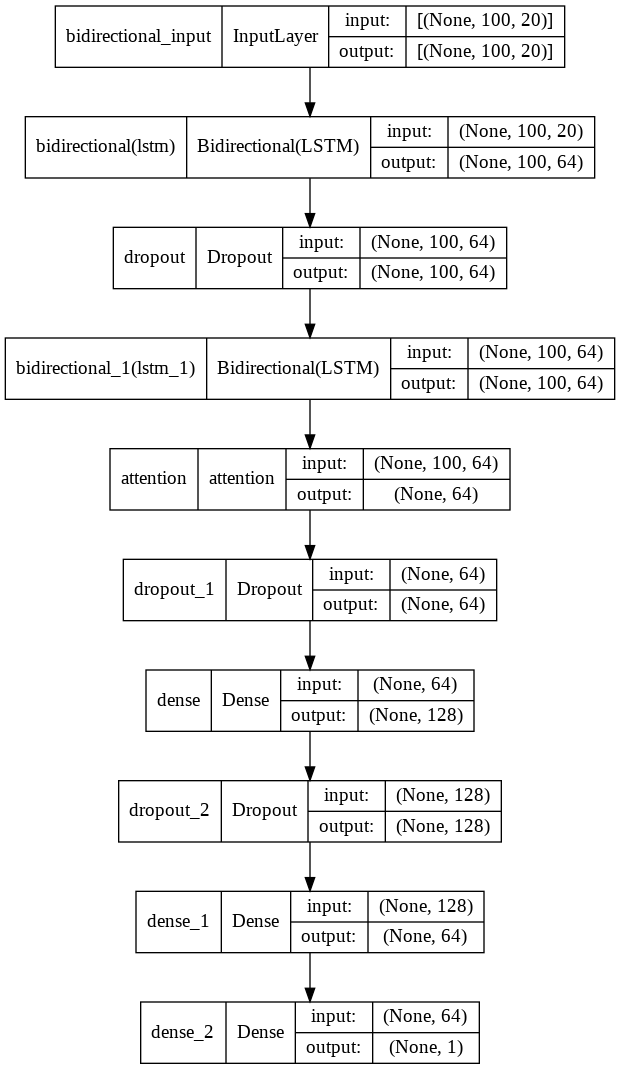

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Evaluation


In [ ]:
# evaluation on validation data 

result_val = model.evaluate(X_val, y_val, verbose=2)
result_val

319/319 - 10s - loss: 0.0038 - mse: 0.0038 - mae: 0.0510 - mape: 15.8189 - 10s/epoch - 30ms/step


[0.003815452801063657,
 0.003815452801063657,
 0.051025934517383575,
 15.81889533996582]

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
print(X_test.shape, y_test.shape)
results = model.evaluate(X_test, y_test, verbose=2)
results



Evaluate on test data
(10180, 100, 20) (10180,)
319/319 - 10s - loss: 0.0051 - mse: 0.0051 - mae: 0.0559 - mape: 6787.7461 - 10s/epoch - 30ms/step


[0.005107327830046415,
 0.005107327830046415,
 0.05591912567615509,
 6787.74609375]

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

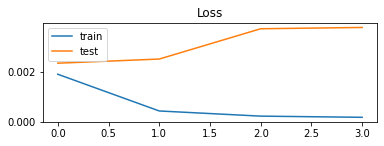

In [ ]:
# plot loss during training
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

In [ ]:
# # plot accuracy during training
# pyplot.subplot(212)
# pyplot.title('Accuracy')
# pyplot.plot(history.history['accuracy'], label='train')
# pyplot.plot(history.history['val_accuracy'], label='test')
# pyplot.legend()
# pyplot.show()

In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
#print("Generate predictions for 1000 samples")
predictions = model.predict(X_test)
print("predictions shape:", predictions.shape)
predictions

predictions shape: (10180, 1)


array([[0.5071959 ],
       [0.5074772 ],
       [0.5077696 ],
       ...,
       [0.85544   ],
       [0.85709846],
       [0.8588466 ]], dtype=float32)

In [ ]:
y_test.shape

(10180,)

In [ ]:
0.75780545- 0.6779263

0.07987915000000001

In [ ]:
from sklearn.metrics import mean_absolute_error
#model.predict(X_test)
MAE = mean_absolute_error(y_test, predictions)
MAE

0.05591912776874677

In [ ]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_test, predictions)
MSE

0.00510732829416087

In [ ]:
from sklearn.metrics import explained_variance_score
#>>> y_true = [3, -0.5, 2, 7]
#>>> y_pred = [2.5, 0.0, 2, 8]
x = explained_variance_score(y_test, predictions)
x

0.9144178976815166

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions, multioutput='variance_weighted')
r2

0.849530219501748



```Backtest 
# This is formatted as code
```

# Back test

In [ ]:
# data = pd.read_csv("AUD_CAD_H1.csv")

# #data = get_TA(data)

In [ ]:
def data_preprocess1(data, pips = 0.00001, pt = 100, sl = 100, window_size = 5, num_features = 225):

    data.index = pd.to_datetime(data.datetime)
    data=data.drop(['datetime'],axis=1)
    data.sort_values(by = 'datetime', ascending = True, inplace = True)
    def getHandL_next_N_window(data, windowSize):
        def idx_max(x):
            return x.index.values[np.argmax(x.values)]
        def idx_min(x):
            return x.index.values[np.argmin(x.values)]
        data_max_next = data['high'].rolling(windowSize).agg(['max', idx_max]).shift(-1*windowSize+1)
        data_min_next = data['low'].rolling(windowSize).agg(['min', idx_min]).shift(-1*windowSize+1)
        data_merged = pd.concat([data, data_max_next, data_min_next], axis=1)
        data_merged = data_merged.rename(columns={'max': 'hh_next_'+str(windowSize), 'idx_max': 'hh_next_idx_'+str(windowSize), 'min': 'll_next_'+str(windowSize), 'idx_min': 'll_next_idx_'+str(windowSize)})
        return data_merged
    
    data = getHandL_next_N_window(data, window_size)
    data['hh_diff_'+str(window_size)]=(data['hh_next_'+str(window_size)]-data['open'])/pips
    data['ll_diff_'+str(window_size)]=(data['open']-data['ll_next_'+str(window_size)])/pips
    conditions = [
        (data['hh_diff_'+str(window_size)]>pt) & (data['ll_diff_'+str(window_size)]<sl),
        (data['hh_diff_'+str(window_size)]>pt) & (data['ll_diff_'+str(window_size)]>sl)
                & (data['hh_next_idx_'+str(window_size)]<data['ll_next_idx_'+str(window_size)]),
        (data['ll_diff_'+str(window_size)]>pt) & (data['hh_diff_'+str(window_size)]<sl),
        (data['ll_diff_'+str(window_size)]>pt) & (data['hh_diff_'+str(window_size)]>sl)
                & (data['ll_next_idx_'+str(window_size)]<data['hh_next_idx_'+str(window_size)]),
    ]
    labels = [0,0,2,2]
    data['label_'+str(window_size)] = np.select(conditions, labels, default=1)

    data['MA_50'] = ta.SMA(data['close'],50)
    data['MA_100'] = ta.SMA(data['close'],100)
    data['Relative'] = ta.RSI(data['close'],14)
    data['EMA'] = ta.EMA(data['close'], timeperiod = 20)
    data['up_band'], data['mid_band'], data['low_band'] = ta.BBANDS(data['close'], timeperiod =20)
    data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    data['avg'] = ta.ADX(data['high'],data['low'], data['close'], timeperiod=20)
    data = data.dropna(axis=0,how='any')

    


  
    #train = data.iloc[:int(len(data) * 0.8),:]
    #valid = data.iloc[int(len(data) * 0.8):int(len(data) * 0.9),:]
    #test = data.iloc[int(len(data) * 0.9):len(data),:]

    test = data.iloc[:len(data),:]
  
  
    def pre_process(df):
      x_data = df.drop(['close','label_5'], axis = 1)

      y_data = df.loc[:,'close']
      # x_data = pd.DataFrame(data.iloc[:,data.colums])
      return x_data, y_data
    

    #X_train, y_train = pre_process(train)
    #X_val, y_val = pre_process(valid)
    X_test, y_test = pre_process(test)

    def data_transform(x, y):
      
      from sklearn.preprocessing import MinMaxScaler
      scaler=MinMaxScaler(feature_range=(0,1))
      x=scaler.fit_transform(np.array(x))  
      y=scaler.fit_transform(np.array(y).reshape(-1,1))  
      

      return x#,y 

    #X_train, y_train = data_transform(X_train, y_train)
    #X_val, y_val =data_transform(X_val,y_val)
    X_test = data_transform(X_test, y_test)


    import numpy
  # convert an array of values into a dataset matrix
    def create_dataset(x, time_step=1):
      dataX, dataY = [], []
      for i in range(len(x)-time_step-1):
          a = x[i:(i+time_step), :]   ###i=0, 0,1,2,3-----99   100 
          dataX.append(a)
          dataY.append(x[i, 1])
          #dataY.append(x[i  : i + time_step])
      
      return numpy.array(dataX)# numpy.array(dataY)

    time_step = 100

    #X_train, y_train = create_dataset(X_train,y_train,time_step)
    #X_val, y_val = create_dataset(X_val,y_val,time_step)
    X_test = create_dataset(X_test,time_step)



    return X_test

In [ ]:
# data = data.dropna()
# print(data_preprocess1(data))

In [ ]:
#def trading_strategyPredition(inputs):
from keras.models import load_model
# Assuming your model includes instance of an "AttentionLayer" class
#model = load_model('my_model.h5', custom_objects={'AttentionLayer': AttentionLayer})
def trading_strategy(inputs):
    df = pd.DataFrame(inputs)
    
    # 
    # load saved model to predict 
    #model = load_model("Bi_lstm_attention")
    #model.compile(loss='mean_squared_error',optimizer='adam')

    df = df.drop(['action','P/L','Total profit'],axis = 1)

    x_data = data_preprocess1(df)
    #x_data = x_data[20:]
    #model.evaluate(x_data, y_data)
    prediction = model.predict(x_data)
    from sklearn.preprocessing import MinMaxScaler
    scaler=MinMaxScaler(feature_range=(0,1)).fit(prediction)
    #prediction = scaler.fit(prediction)
    prediction = scaler.inverse_transform(prediction)
    #predicted_target = prediction.argmax(axis=-1)[0]

    close =df['close'].iloc[-1]
    value= prediction - close
    
    #print(prediction)
    
    # return trading action
    if value > 0.0002: 
        return 1 # which is buy
    elif value < -0.0002: 
        return -1 #which is sell
    else: 
        return 0 # hold 

In [ ]:
# d = trading_strategy(data)

Time consumed: 976.82s


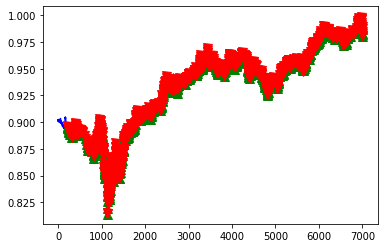

In [ ]:
import os

import pandas as pd
pd.options.mode.chained_assignment = None
import time
from collections import deque
from signalHandler import signalHandler
from visualise import visualise

############# READ FILE #############

#data = pd.read_csv('GBPUSD_H1_202001020600_202006010000.csv',sep='\t', skiprows=1, names = ['date', 'time', 'open', 'high', 'low', 'close', 'tickvol','vol','spread' ])
#data = pd.read_csv('EURUSD_M30.csv',sep=',', skiprows=1, names = ['time', 'open', 'high', 'low', 'close', 'tickvol','vol','spread' ])
#data = pd.read_csv('EURUSD_M30.csv',sep='\t', skiprows=1, names = ['date', 'time', 'open', 'high', 'low', 'close', 'tickvol','vol','spread' ])
#data = data.drop(['tickvol', 'vol','spread'], axis=1)  # we do not need these coloumns

df_test = pd.read_csv("AUD_CAD_H1.csv")
df_test = df_test.tail(7000)

model = load_model("Bi_lstm_attention")

############# Hyperparameters #############
input_row_size = 205     # <----- Minimum number of inputs required by YOUR trading strategy
one_pip = 0.0001            # <----- Indicating the value of 1 pip, i.e. usually 0.0001 for all major fx except for JPY pairs (0.01)
stop_loss = -10*one_pip     # <----- (THIS WILL CHANGE!!, if the code recieves opposite signal than previously executed order then the position will be closed. 
take_profit = 20*one_pip    # <----- For example. If we holding a buy pisition and sell signal received (labeled as buyy_sell in signalHandler.py) then the position will be closed. 
broker_cost = 2*one_pip
inputs = deque(maxlen=input_row_size)
############# BACKTESTING #############
# Handels Buy and Sell
broker = signalHandler(stop_loss,take_profit,broker_cost,df_test)

start_time = time.time() 
index = 0
signal = 0
for _,row in df_test.iterrows():

    # Loading the inputs array till the 
    # minimum number of inputs are reached
    inputs.append(row)
    
    if len(inputs) == input_row_size:
      
        signal = trading_strategy(list(inputs)) #  call trading strategy. It will return one of the following 1 (Buy), 0 (do nothing) or -1 (sell)

        # Current Price
        current_price = row['close']  
        
        # Checks signal and executes
        if signal == 1:
            broker.buy(current_price,index)
        elif signal == -1:
            broker.sell(current_price,index)
        elif signal == 0:
            # Checking if stop loss or take profit is hit
            broker.checkStopConditions(current_price,index)
        else:
            print("Unknown Signal")
            break
     
    index += 1

end_time = time.time()
print("Time consumed: {}s".format(round(end_time-start_time,2)))
#print()

final_data = broker.getData() # <----- Gets Data into a DATAFRAME
final_data.to_csv('backtesting.csv')
# final_data has THREE new coloumns
#   'action'        : The action the code implemented at that timestep.
#   'P/L'           : The profit or loss at the time step, 0 when holding.
#   'Total profit'  : The total profit TILL that time step. 

############# VISUALISEING #############
visualiser = visualise(final_data)
visualiser.plotFig()